In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-06 by mza
name = "mza_try9"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 512, 512, 512 ]
hidden_node_type = "relu"
truths_to_use = [ 1 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
integer_part = 1
input_quantization = 16
inner_quantization = 16
output_quantization = 16

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.09679624557495117


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
input_quantizer = quantized_bits(input_quantization, integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 2ms/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 512]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 512]], output shape: [None, 512]
Layer name: relu1qdense, layer type: QDense, input shapes: [[None, 512]], output shape: [None, 512]
Layer name: relu1activation, layer type: Activation, input shapes: [[None, 512]], output shape: [None, 512]
Layer name: relu2qdense, layer type: QDense, input shapes: [[None, 512]], output shape: [None, 512]
Layer name: relu2activation, layer type: Activation, input shapes: [[None, 512]], output shape: [None, 512]
Layer name: output_q

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

Writing HLS project


/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

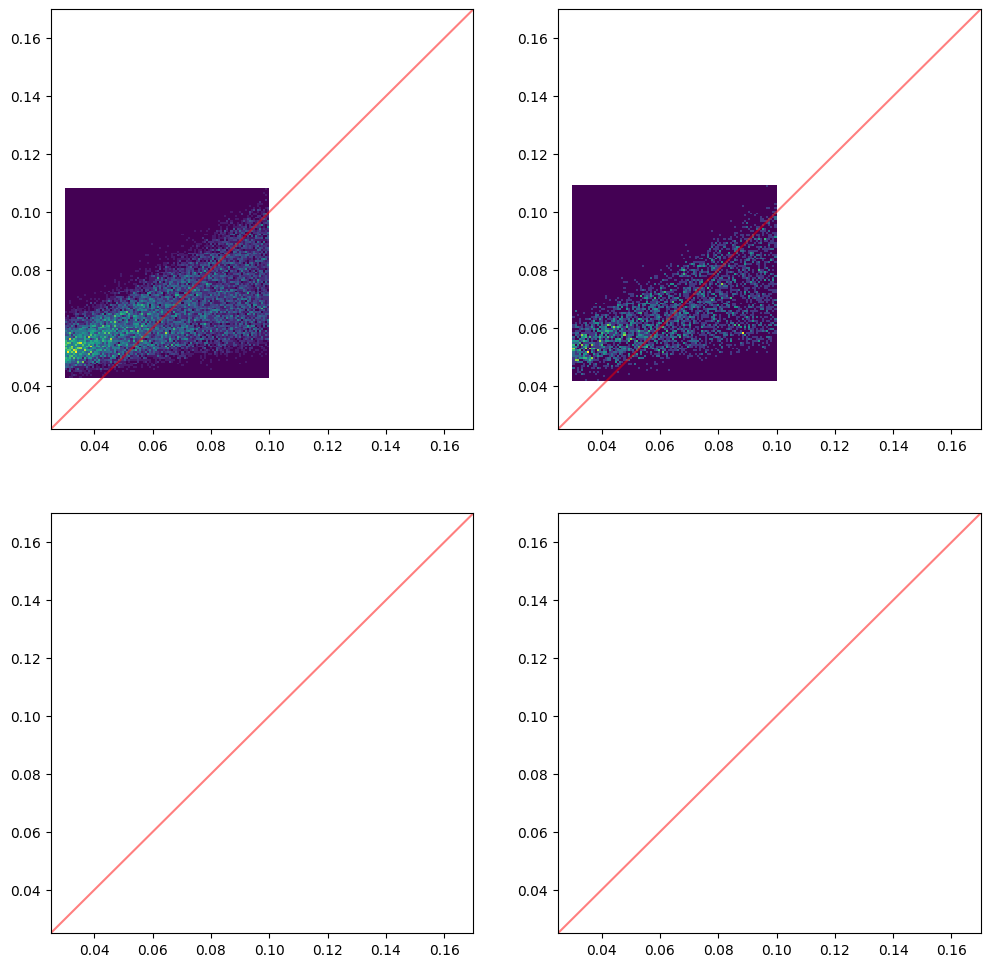

In [17]:
nbins = 100
a = 0.025; b = 0.17
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [18]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True) # ERROR: [HLS 200-1715] Encountered problem during source synthesis


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Tue May 06 14:49:42 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try9/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try9/hls4ml_prj/myproject_prj'.
INFO: [

CSynthesis report not found.
Vivado synthesis report not found.
Cosim report not found.
Timing report not found.


In [19]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj')

Found 1 solution(s) in mza_try9/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.0610964 
Quantized predictions
0.306641 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

Synthesis report not found.
Co-simulation report not found.
